<a href="https://colab.research.google.com/github/kenanEkici/COVID19-fake-tweet-detection-XAI/blob/main/Masterproef_HCI_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Introduction

# 2) Imports

In [1]:
#lime
#!pip install lime -q
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

# for hydrating tweet ids
#!pip install twarc -q

#utils
import os
import re
import json
import random
from datetime import datetime
from shutil import copyfile
import string
from string import ascii_letters
from collections import Counter, defaultdict
from scipy.stats import iqr

#math, data
import math
import numpy as np
from numpy import inf
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import  word_tokenize 
from textblob import TextBlob
from sklearn.utils import shuffle

#plots, image
import cv2
from skimage import io
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

#ml, nlp
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manmanhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manmanhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manmanhuang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 3) Collecting raw data


The first step is to search for labeled datasets (labeled as misinformation or not) of Tweets and news articles that might contain false claims or other misleading information about COVID-19. We will need this dataset to build a supervised machine learning classifier to detect Tweets that contain misinformation. The first source that was found contains hundreds of Tweet ID's, which are a reference to the actual Tweets on Twitter. The second and third source contain both Tweets, news articles and website claims. The news articles and claims will be an additional source to extract language features that may be important to classify fake news. We are interested in both objective or subjective claims and news articles. The Tweets are more rich in information as they they come with more features and can contain any kind of content unlike news articles which only contain news. Unfortunately due to privacy reasons, the Tweets have been compressed to their ID and the ID of the users that posted the Tweet. This means that we will need a third party library such as Twarc in order to collect the actual Tweets which the ID's reference to. In the context of Twitter this is also referred to as "rehydration". The last source contains ID's of users that were labeled as either social bot or real accounts. We need this source as we will train a supervised classifier for detecting social bots. We discussed that these could be an important source and indicator of misinformed Tweets. These must also be rehydrated using the third party library.

Source #1: https://github.com/firojalam/COVID-19-tweets-for-check-worthiness (Downloaded 06-10-2020)

Source #2: https://github.com/cuilimeng/CoAID (Downloaded 06-10-2020)

Source #3: https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv (Downloaded 06-10-2020)

Source #4: http://mib.projects.iit.cnr.it/dataset.html (Downloaded 06-10-2020)

## Source 1

The first source contains COVID-19 related Tweets that have been extensively labeled by a community. The Tweets are categorized based on the answers they provide to the following questions:

- Q1: "Does the tweet contain a verifiable factual claim?"
- Q2: "To what extent does the tweet appear to contain false information?"
- Q3: "Will the tweet’s claim have an effect on or be of interest to the general public?"
- Q4: "To what extent does the tweet appear to be harmful to society, person(s), company(s) or product(s)?"
- Q5: "Do you think that a professional fact-checker should verify the claim in the tweet?"
- Q6: "Is the tweet harmful for society and why?"
- Q7: "Do you think that this tweet should get the attention of a government entity?"

The provided TSV file is loaded as a dataframe. The dataframe contains the ID and textual content of the Tweet as well as columnn that each represent one of the questions above. The columns (questions) have a variety of possible answers (refer to Github source 1). Thus, it is possible to filter out some of the Tweets from the dataframe that are not relevant. For the final misclassification Tweet dataset, we add every Tweet which contains the following answers: "yes" to question 1, "yes, probably or definitely contains false info" to question 2, and "yes, either urgent or not urgent" to question 5. 

In [2]:
df = pd.read_csv('RawData/covid19_infodemic_english_data.tsv', sep='\t')

In [3]:
df_1 = df.loc[df['q1_label'] == 'yes']
df_1 = df.loc[(df['q2_label'] == '4_yes_probably_contains_false_info') | (df['q2_label'] == '5_yes_definitely_contains_false_info')]
df_1 = df.loc[(df['q5_label'] == 'yes_not_urgent') | (df['q5_label'] == 'yes_very_urgent')]
df_1.head()

,tweet_id,text,q1_label,q2_label,q3_label,q4_label,q5_label,q6_label,q7_label
4,1241447017945223169,This is the face of someone who just spent 9 h...,yes,2_no_probably_contains_no_false_info,4_yes_probably_of_interest,1_no_definitely_not_harmful,yes_not_urgent,no_not_harmful,no_not_interesting
11,1240676575168921600,"So, the last week I have been battling COVID-1...",yes,2_no_probably_contains_no_false_info,4_yes_probably_of_interest,2_no_probably_not_harmful,yes_not_urgent,no_not_harmful,yes_blame_authorities
13,1240768501452697600,He told wealthy friends. Then cashed out a coo...,yes,3_not_sure,5_yes_definitely_of_interest,5_yes_definitely_harmful,yes_not_urgent,yes_rumor_conspiracy,yes_blame_authorities
15,1241337295606657033,Korea finished developing the 10 minute Covid-...,yes,2_no_probably_contains_no_false_info,5_yes_definitely_of_interest,1_no_definitely_not_harmful,yes_not_urgent,no_not_harmful,yes_discusses_action_taken
19,1241057919128526856,"THREAD: I mostly talk about movies on here, bu...",yes,2_no_probably_contains_no_false_info,4_yes_probably_of_interest,1_no_definitely_not_harmful,yes_not_urgent,no_not_harmful,yes_discusses_action_taken


In [4]:
# We only need the Tweet ID's
tweets_fake_1 = df_1['tweet_id']
print("This dataset contains",df_1.shape[0], "Tweet ID's")

This dataset contains 160 Tweet ID's


## Source 2

https://arxiv.org/pdf/2006.00885.pdf

The second source CoAID contains both factual and misleading COVID-19 claims from websites and news articles. It also contains Tweets that make COVID-19 related claims or share related news. The factual articles and claims have collected from reliable media outlets and websites such as WHO's official website.The fake news articles have been collected from fact-checking websites such as PolitiFact. The Tweets were queried based whether they contained news titles of misleading or factual news and thus labeled accordingly. The paper also presents important insights on the CoAID dataset such as the frequency of the hashtags used in both fake and real news and a list common claims. For our dataset, we collect only the labeled claims, news articles, and Tweets (both news and claims) but not the user replies. 

In [5]:
def read_content_from_folder(dir_name): 
  fake_claims = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19.csv'))['title']
  fake_claims = pd.DataFrame({'content':fake_claims})
  fake_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19_tweets.csv'))['tweet_id']
  fake_news =  pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19.csv'))[['title', 'content']]
  fake_news['content'] = fake_news['title'].replace(np.nan, '', regex=True) + ' ' + fake_news['content'].replace(np.nan, '', regex=True)
  fake_news = pd.DataFrame({'content':fake_news['content']})
  fake_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19_tweets.csv'))['tweet_id']

  real_claims = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19.csv'))['title']
  real_claims = pd.DataFrame({'content':real_claims})
  real_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19_tweets.csv'))['tweet_id']
  real_news =  pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19.csv'))[['title', 'content']]
  real_news['content'] = real_news['title'].replace(np.nan, '', regex=True) + ' ' + real_news['content'].replace(np.nan, '', regex=True)
  real_news = pd.DataFrame({'content':real_news['content']})
  real_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19_tweets.csv'))['tweet_id']

  return [fake_claims, fake_claims_tweets, fake_news, fake_news_tweets, real_claims, real_claims_tweets, real_news, real_news_tweets]

l1 = read_content_from_folder('RawData/05-01-2020/')
l2 = read_content_from_folder('RawData/07-01-2020/')

all_dfs = []

# merging two lists, reset index
for i, dataframe in enumerate(l1):
  all_dfs.append(dataframe.append(l2[i], ignore_index=True))

fc, fct, fn, fnt, rc, rct, rn, rnt = all_dfs

In [6]:
# join previous fake claims tweet id's with new collectd id's
fct = tweets_fake_1.append(fct, ignore_index=True)

## Source 3

The third source contains around 500 factual and 500 misleading news articles collected by the author of https://towardsdatascience.com/covid-fake-news-detection-with-a-very-simple-logistic-regression-34c63502e33b, senior data scientist Susan Li. We collect both the content and the title of the articles and combine them in one column. 

In [7]:
# code from: https://github.com/susanli2016/NLP-with-Python/blob/master/Fake_News_LogReg.ipynb
df = pd.read_csv('RawData/corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5,'label'] = 'FAKE'
df.loc[15,'label'] = 'TRUE'
df.loc[43,'label'] = 'FAKE'
df.loc[131,'label'] = 'TRUE'
df.loc[242,'label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

df['title_text'] = df['title'] + ' ' + df['text']
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text
    
df['title_text'] = df['title_text'].apply(preprocessor)
df['label'].value_counts()

TRUE    586
FAKE    578
Name: label, dtype: int64

In [8]:
df_t = pd.DataFrame({'content':df.loc[df['label']=='TRUE','title_text']})
df_f = pd.DataFrame({'content':df.loc[df['label']=='FAKE','title_text']})

In [9]:
fn = fn.append(df_f, ignore_index=True)
rn = rn.append(df_t, ignore_index=True)

## Source 4

The last dataset contains a list of Twitter user ID's of both bots and real accounts which have been labeled through CrowdFlower, a crowdsourcing platform. This data will be necessary to train the social bot classifier in a later section. Due to privacy reasons, the dataset may not be distributed. You can request the dataset from the authors or use another source. For the latter case, please replace the file paths below with the path of a text file containing a list of Twitter user ID's. 

In [10]:
bot_user_id = pd.read_csv("RawData/cresci_fake_users.txt", header=None)
real_user_id = pd.read_csv("RawData/cresci_real_users.txt", header=None)

## Raw dataframes

We now have collected all of the necessary data. Although the claims and articles are raw strings, the Tweets are ID's (due to privacy reasons) and thus must be fetched explictely from the Twitter API. In the next section, we will use Twarc to fetch the Twitter level data.   

In [11]:
dataframes = [("fake_claims", fc), ("fake_claims_tweets", fct), ("fake_news", fn), ("fake_news_tweets", fnt), 
              ("real_claims", rc), ("real_claims_tweets", rct), ("real_news", rn), ("real_news_tweets", rnt),
              ("bot_users", bot_user_id), ("real_users", real_user_id)]

[print(i[0], len(i[1])) for i in dataframes]
print()

fake_claims 28
fake_claims_tweets 644
fake_news 1416
fake_news_tweets 10416
real_claims 338
real_claims_tweets 7795
real_news 3303
real_news_tweets 141548
bot_users 3455
real_users 3474



# 4) Rehydrating Tweet ID'S

We will use Twarc to rehydrate the Twitter ID's that we collected in the previous section. Twarc will rehydrate the ID's and collect the Twitter level data. This includes the Tweet and the data of the user that posted the Tweet. We will rehydrate both the Tweet ID's and the user ID's that we have collected in the previous section. In order to use Twarc, you will need a Twitter developer key and access token which you can request from the Twitter developer API.  


In [12]:

def read_json(filename):
  tweets = []
  with open(filename) as f:
    for line in f:
      tweets.append(json.loads(line))
  return tweets  

As you can verify below, after collecting the Tweets from the API, the amount of entries are a lot less than the actual raw data. This is because some of the Tweets (and users) may have been deleted and thus resulted into empty entries.

In [13]:
# these contain both Tweet data and user data
tweets_fake_ = read_json('Classified/tweets_fake.jsonl')
tweets_real_ = read_json('Classified/tweets_real.jsonl')

# these only contain user data
users_fake_ = read_json('Classified/fake_users.jsonl')
users_real_ = read_json('Classified/real_users.jsonl')

#sanity check
print(len(tweets_fake_))
print(len(tweets_real_))
print(len(users_fake_))
print(len(users_real_))

10165
142761
2804
2892


# 5) Feature selection and mining

## Feature selection

Now that we have collected the Tweets and users in JSON format, we can determine which columns we want to keep for the final dataset. After all, the API returns a large set of columns and features. Some of these feature are not necessary for building the classifiers. We have defined two helper functions to convert the JSON files of both Tweets and users to a Pandas dataframe. This will be easier to work with when doing analysis. We will also simultaneously filter the columns that are redundant. 

All the features and their descriptions can be found at:

- Users: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user

- Tweets: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

In [14]:
tweet_columns = ["id", "source", "full_text", "retweet_count", "favorite_count", "possibly_sensitive", "entities", "created_at"]
user_columns = ["id", "name", "screen_name", "has_extended_profile", "location", "description", "url", "protected", "followers_count", "friends_count", "listed_count", "created_at", "favourites_count", "verified", "statuses_count", "profile_image_url_https", "default_profile", "default_profile_image"]

# this function will be used to convert the json files that contain
# both the tweet level and user level data to a Pandas dataframe
def json_to_dataframe(json, amount):
  tweets = []
  users = []
  for i, t in enumerate(json):
    tweet_row = []
    user_row = []
    for _, tc in enumerate(tweet_columns):
      if (tc == "possibly_sensitive"):
        if "possibly_sensitive" in t:
          tweet_row.append(t["possibly_sensitive"])
        else:
          tweet_row.append(False)
      else:
        tweet_row.append(t[tc])    
    for _, tu in enumerate(user_columns):
      user_row.append(t['user'][tu])
    tweets.append(tweet_row)
    users.append(user_row)
  df_t = pd.DataFrame(data= tweets, columns=tweet_columns)
  df_u = pd.DataFrame(data=users, columns=user_columns)

  return df_t[0:amount], df_u[0:amount]

# this function will be used to convert only the json files
# that contain user level data to a Pandas dataframe
def user_json_to_dataframe(json):
  users = []
  for i, u in enumerate(json):
    user_row = []
    for _, tu in enumerate(user_columns):
      user_row.append(u[tu])
    users.append(user_row)
  df_u = pd.DataFrame(data=users, columns=user_columns)
  return df_u

## Data mining

The literature and related work proposes a variety of techniques to improve classification of anomalous behavior such as social bots or fake news. Data mining is such a technique in which new knowledge is inferred from existing data. We will use this technique to generate new columns from the existing ones that were retrieved from the API. An example of these features are username length, likes and age ratio or the ratio of friends to followers. The following functions will be used to mine such features. 

In [15]:
#https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7

#https://medium.com/pew-research-center-decoded/detecting-subjectivity-and-tone-with-automated-text-analysis-tools-5f0e662224b8

def calculate_is_subjective(mined_data):
  def textblob_adj(text):
      blobed = TextBlob(text)
      counts = Counter(tag for word,tag in blobed.tags)
      adj_list = []
      adv_list = []
      adj_tag_list = ['JJ','JJR','JJS']
      adv_tag_list = ['RB','RBR','RBS']
      for (a, b) in blobed.tags:
        if b in adj_tag_list:
          adj_list.append(a)
        elif b in adv_tag_list:
          adv_list.append(a)
        else:
          pass
      return adj_list, adv_list, counts['JJ']+counts['JJR']+counts['JJS'], counts['RB']+counts['RBR']+counts['RBS'], counts['NNP']
    
  mined_data['subjective'] = 0
  mined_data['n_nnp'] = 0

  for i, k in mined_data.iterrows():
    adj, adv, adj_c, adv_c, nnp_c = textblob_adj(k['full_text'])
    mined_data['n_nnp'].loc[i] = nnp_c
    if (adj_c >= 2 and adv_c >=1):
      mined_data['subjective'].loc[i] = 1
  return mined_data

def preprocess_tweet(mined_data):
  def add_amount_features(col_name, char):
    mined_data[col_name] = 0
    for i, s in enumerate(mined_data['full_text']):
      n_q = 0
      for k in s:
        if (k == char):
          n_q +=1
      mined_data[col_name].loc[i] = n_q

  add_amount_features('n_question', '?')
  add_amount_features('n_exclaim', '!')
  add_amount_features('n_hash', '#')
  mined_data['n_uppercase'] = mined_data['full_text'].str.findall(r'[A-Z]').str.len()
  mined_data['length'] = mined_data['full_text'].str.len()
  mined_data['created_at_tweet'] = mined_data['created_at']
    
  mined_data['has_link'] = False
  for i, s in enumerate(mined_data['full_text']):
    mined_data.loc[i, 'has_link'] = ('t.co' in s) or ('http' in s)
  mined_data['has_link'] = mined_data['has_link'].astype(int)
  mined_data['possibly_sensitive'] = mined_data['possibly_sensitive'].astype(int)
  mined_data = calculate_is_subjective(mined_data)

  return mined_data

def preprocess_users(mined_data, bot=False):
  
  mined_data['bio_length'] = mined_data['description'].apply(len)
  mined_data['username_length'] = mined_data['screen_name'].apply(len)
  mined_data['name_length'] = mined_data['name'].apply(len)
  date_format = "%a %b %d %H:%M:%S +%f %Y" 
  mined_data['age_account_days'] = 0
  for i, r in enumerate(mined_data['created_at']):
    a = None
    if (bot):
      a = datetime(2017, 4, 30)
    else: 
      a = datetime.now()
    b = datetime.strptime(r, date_format)
    mined_data['age_account_days'].iloc[i] = (a - b).days

  mined_data['created_at_user'] = mined_data['created_at']
  
  mined_data['friends_count'] = mined_data['friends_count'].replace([0],1)
  mined_data['followers_friends_ratio'] = (mined_data['followers_count'] / mined_data['friends_count'])
  mined_data['tweet_age_ratio'] = (mined_data['statuses_count'] /mined_data['age_account_days']) 
  mined_data['age_account_days'] = mined_data['age_account_days'].replace([0],1)
  mined_data['likes_age_ratio'] = (mined_data['favourites_count'] / mined_data['age_account_days'])

  mined_data['verified'] = mined_data['verified'].astype(int)
  mined_data['has_location'] = mined_data['location'] != ''
  mined_data['has_location'] = mined_data['has_location'].astype(int)
  mined_data['default_profile_image'] = mined_data['default_profile_image'].astype(int)
  mined_data['default_profile'] = mined_data['default_profile'].astype(int)
  mined_data['protected'] = mined_data['protected'].astype(int)
  mined_data['has_url'] = mined_data['url'].astype(str) != "None"
  mined_data['has_url'] = mined_data['has_url'].astype(int)
 
  return mined_data

During the retrieval of the raw data, it was rather evident that there was more data of normal behavior (factual news), then there is of anomalous behavior (fake news). This is a known problem in supervised classification of anomalous behavior which is due the fact that anomalies occur less often. Below, we make sure that we maintain a balanced dataset for training. 

In [20]:
# these contain fake/real news and claims of Twitter users 
# as well as the users that posted them
amount = 10000
tweets_fake, tweets_fake_users = json_to_dataframe(tweets_fake_, amount)
tweets_real, tweets_real_users = json_to_dataframe(tweets_real_, amount)
tweets_fake = preprocess_tweet(tweets_fake)
tweets_real = preprocess_tweet(tweets_real)

# we preprocess the previous users and mine relevant features
tweets_fake_users = preprocess_users(tweets_fake_users)
tweets_real_users = preprocess_users(tweets_real_users)

# these will be used to train the social bot detector 
bots = preprocess_users(user_json_to_dataframe(users_fake_), True)
non_bots = preprocess_users(user_json_to_dataframe(users_real_), True)

## Finalized dataset

We have now collected all the required data and mined the features that are necessary for further analysis and the development of the supervised classifiers. However, before we develop the classifiers, we must do analyze the dataset in order to gain an insight on both the features and their correlation with the target labels that we aim to predict. This process will help to determine which features are useful and which are not.

**The final dataset that we will continue using consists of:**



In [23]:
fake_news_articles = fn
real_news_articles = rn
print(len(fake_news_articles), "Fake and", len(real_news_articles), "real news articles (text)")

fake_claims = fc
real_claims = rc
print(len(fake_claims), "fake and", len(real_claims), "real website claims (text)")

print(len(tweets_fake), "fake and", len(tweets_real), "real news and claims (tweets)")

print("The corresponding", len(tweets_fake_users)+len(tweets_real_users) ,"users that posted these fake real claims and news (users)")

#print("The corresponding", len(tweets_fake_users_study)+len(tweets_real_users_study) ,"users that posted these fake real claims and news (users) - version for user study")
 
print(len(bots), "bots and", len(non_bots), "real users (users)")

1416 Fake and 3303 real news articles (text)
28 fake and 338 real website claims (text)
10000 fake and 10000 real news and claims (tweets)
The corresponding 20000 users that posted these fake real claims and news (users)
2804 bots and 2892 real users (users)


# 6) Data analysis

## Misinformation

We analyze the data to find features that are highly correlated with the target label (fake or not fake news). In this section, we will analyze the Twitter data which consists of both the Tweet level data and user level data. In order to do this, we explicitly label fake news (and claims) with the number <b>one</b>, and the factual news (and claims) with <b>zero</b>.  

In [24]:
# 20K users 
tweets_users = (tweets_fake_users.append(tweets_real_users, ignore_index=True))
# 20K tweets
tweets = (tweets_fake.append(tweets_real, ignore_index= True))

# 20K corresponding labels
y = np.concatenate((np.ones(len(tweets_fake)), np.zeros(len(tweets_real))))

tweets_and_users = pd.concat([tweets, tweets_users.drop(["id"], axis=1)], axis=1)
tweets_and_users['label'] = y

tweets_and_users_ = tweets_and_users.copy()

### Social impact

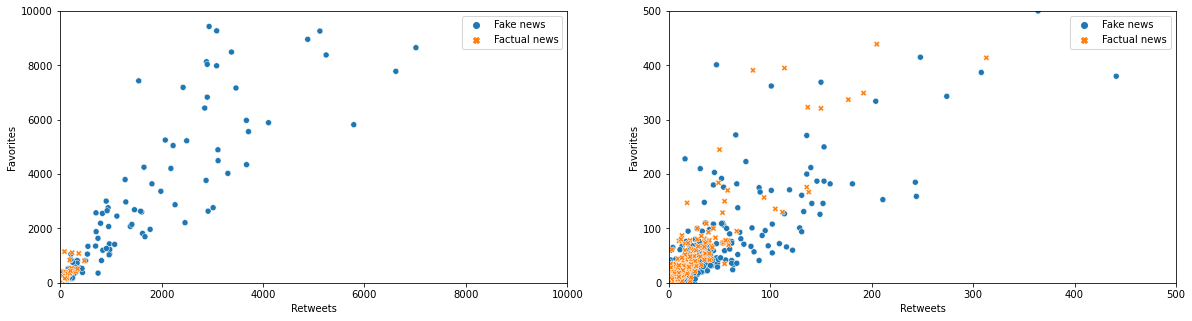

In [25]:
def get_hue(y):
  k = []
  for o in y:
    if o == 0:
      k.append("Factual news")
    else:
      k.append("Fake news")
  return k

fig, axs = plt.subplots(ncols=2, figsize=(20,5))
sns.scatterplot(data=tweets_and_users, x="retweet_count", y="favorite_count", style=get_hue(y), hue=get_hue(y), ax=axs[0])
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,10000)
axs[0].set_xlabel("Retweets")
axs[0].set_ylabel("Favorites")
ax = sns.scatterplot(data=tweets_and_users, x="retweet_count", y="favorite_count", style=get_hue(y), hue=get_hue(y), ax=axs[1])
axs[1].set_xlim(0,500)
axs[1].set_ylim(0,500)
axs[1].set_xlabel("Retweets")
axs[1].set_ylabel("Favorites")
#plt.savefig('Junk/socialimpact.jpg')
print()

In [26]:
# helper function to plot the correlation matrix
def plot_correlation_matrix(d):
  sns.set_theme(style="white")
  corr = d.corr("spearman")
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(5, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
  

<AxesSubplot:>

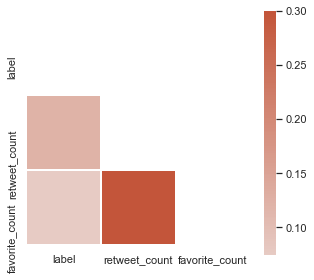

In [27]:
plot_correlation_matrix(tweets_and_users[["label","retweet_count", "favorite_count"]])

### Tweet text

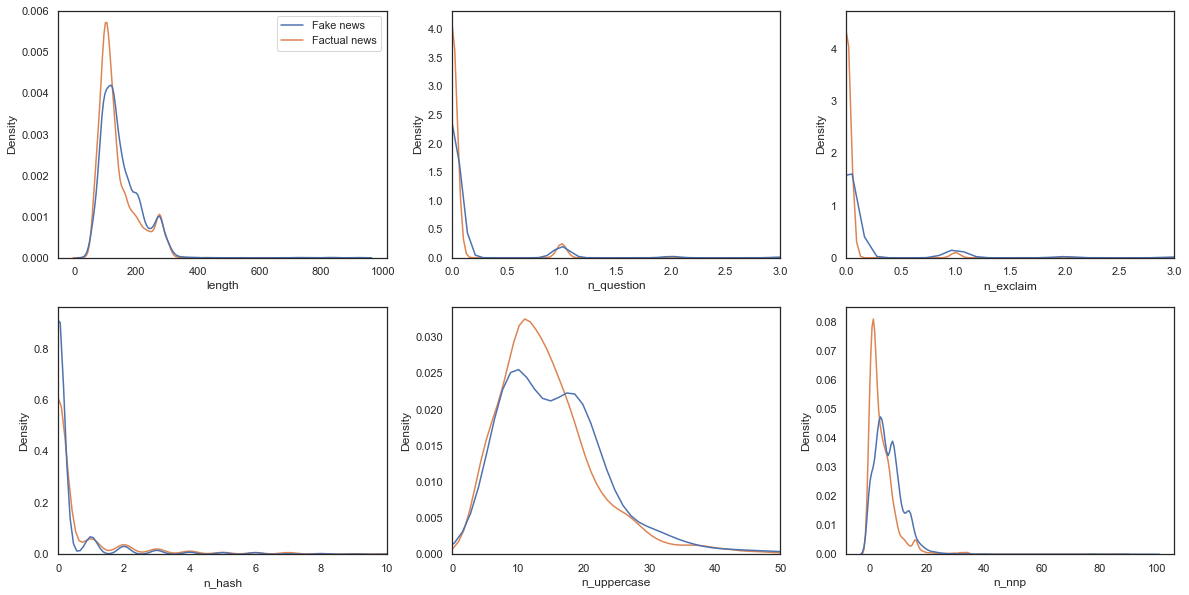

In [28]:
fig, axs = plt.subplots(2,3, figsize=(20,10))
def get_hue(y):
  k = []
  for o in y:
    if o == 0:
      k.append("Factual news")
    else:
      k.append("Fake news")
  return k

sns.kdeplot(data=tweets_and_users, x="length", hue=get_hue(y), ax=axs[0,0])
sns.kdeplot(data=tweets_and_users, x="n_question", hue=get_hue(y) ,ax=axs[0,1], legend=False)
axs[0,1].set_xlim(0,3)
sns.kdeplot(data=tweets_and_users, x="n_exclaim", hue=get_hue(y), ax=axs[0,2], legend=False)
axs[0,2].set_xlim(0,3)
sns.kdeplot(data=tweets_and_users, x="n_hash", hue=get_hue(y), ax=axs[1,0], legend=False)
axs[1,0].set_xlim(0,10)
sns.kdeplot(data=tweets_and_users, x="n_uppercase", hue=get_hue(y), ax=axs[1,1], legend=False)
axs[1,1].set_xlim(0,50)
sns.kdeplot(data=tweets_and_users, x="n_nnp", hue=get_hue(y), ax=axs[1,2], legend=False)

print()

<AxesSubplot:title={'center':'n_nnp'}, xlabel='label'>

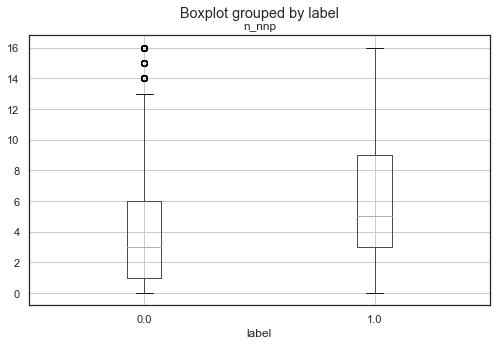

In [29]:
iqr_ = iqr(tweets_and_users["n_nnp"].tolist())
q1 = tweets_and_users["n_nnp"].quantile(0.25)
q3 = tweets_and_users["n_nnp"].quantile(0.75)
fence_low  = q1-1.5*iqr_
fence_high = q3+1.5*iqr_
outliers = ~((tweets_and_users["n_nnp"] > fence_low) & (tweets_and_users["n_nnp"] < fence_high))
for i,k in tweets_and_users[outliers].iterrows():
  tweets_and_users.loc[i, ["n_nnp"]] = tweets_and_users["n_nnp"].median()
tweets_and_users.boxplot(column=["n_nnp"], by='label', figsize=(8,5))

<AxesSubplot:>

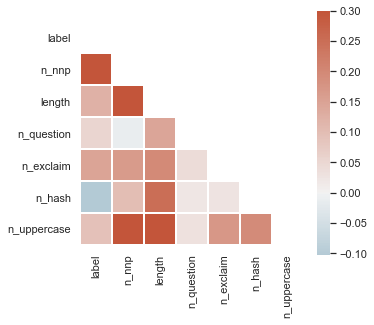

In [30]:
plot_correlation_matrix(tweets_and_users[["label", "n_nnp", "length", "n_question", "n_exclaim", "n_hash", "n_uppercase"]])

### User characteristics

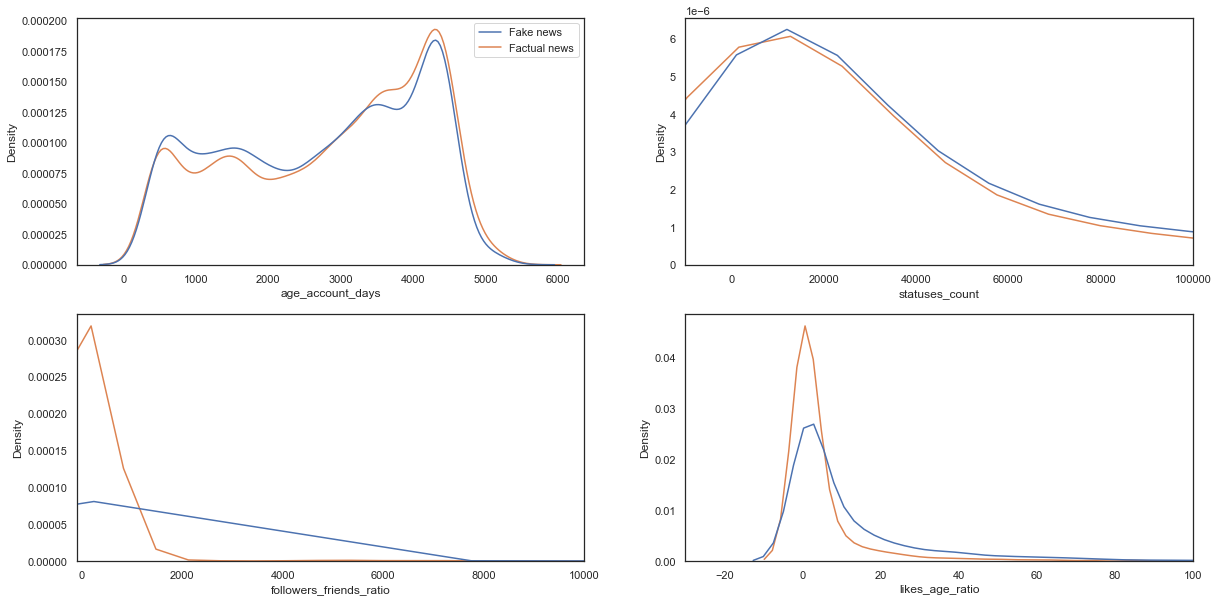

In [31]:
fig, axs = plt.subplots(2,2, figsize=(20,10))


def get_hue(y):
  k = []
  for o in y:
    if o == 0:
      k.append("Factual news")
    else:
      k.append("Fake news")
  return k
  
sns.kdeplot(data=tweets_and_users, x="age_account_days", hue=get_hue(y), ax= axs[0,0], )
sns.kdeplot(data=tweets_and_users, x="statuses_count", hue=get_hue(y), ax= axs[0,1], legend=False)
axs[0,1].set_xlim(-10000,100000)
sns.kdeplot(data=tweets_and_users, x="followers_friends_ratio", hue=get_hue(y), ax= axs[1,0], legend=False)
axs[1,0].set_xlim(-100,10000)
sns.kdeplot(data=tweets_and_users, x="likes_age_ratio", hue=get_hue(y), ax=axs[1,1], legend=False)
axs[1,1].set_xlim(-30,100)

print()

<AxesSubplot:title={'center':'likes_age_ratio'}, xlabel='label'>

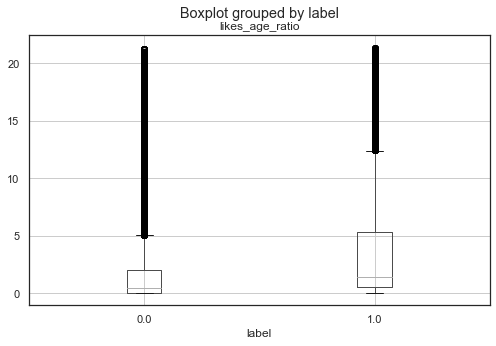

In [32]:
iqr_ = iqr(tweets_and_users["likes_age_ratio"].tolist())
q1 = tweets_and_users["likes_age_ratio"].quantile(0.25)
q3 = tweets_and_users["likes_age_ratio"].quantile(0.75)
fence_low  = q1-1.5*iqr_
fence_high = q3+1.5*iqr_
outliers = ~((tweets_and_users["likes_age_ratio"] > fence_low) & (tweets_and_users["likes_age_ratio"] < fence_high))
for i,k in tweets_and_users[outliers].iterrows():
  tweets_and_users.loc[i, ["likes_age_ratio"]] = tweets_and_users["likes_age_ratio"].median()
tweets_and_users.boxplot(column=["likes_age_ratio"], by='label', figsize=(8,5))

<AxesSubplot:>

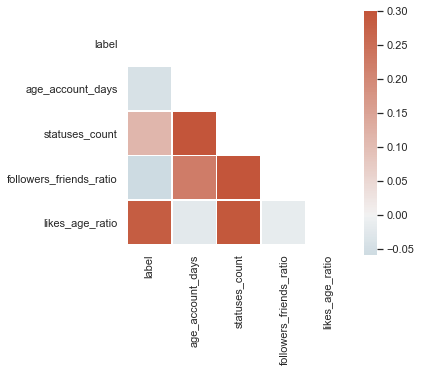

In [33]:
plot_correlation_matrix(tweets_and_users[["label", "age_account_days", "statuses_count", "followers_friends_ratio", "likes_age_ratio"]])

### Hashtag occurence

In [34]:
tweets_and_users.dropna(subset=['full_text'], axis=0, inplace=True)

In [35]:
# extract hashtags
tweets_and_users["hashtag"] = tweets_and_users["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))

# https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

too_obv = ["corona", "covid", "virus"]

# preprocessing hashtags
def clean_hashtags(content):
  words = content.split()
  result  = [word.lower() for word in words if not word.lower().strip().startswith(tuple(too_obv))]
  content = ' '.join(result)
  return content

def collect_hashtags(df):
  hashes = []
  for i, k in df.iterrows():
    for hash in k["hashtag"]:
      hashes.append(hash)
  return hashes


def frame_to_words(hashes):
  words = ""
  for hash in hashes:
    words += hash + " "
  return clean_hashtags(words)

hashes_fake = collect_hashtags(tweets_and_users[tweets_and_users["label"]==1])
hashes_real = collect_hashtags(tweets_and_users[tweets_and_users["label"]==0])

words = frame_to_words(hashes_fake)
w1 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)

words = frame_to_words(hashes_real)
w2 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)

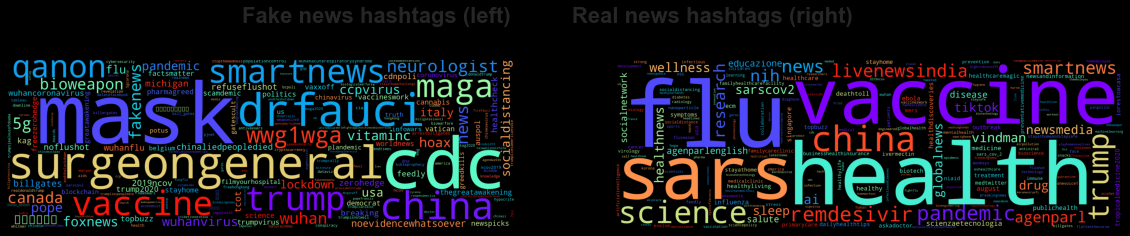

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
fig.suptitle('Fake news hashtags (left)          Real news hashtags (right)', fontsize=22, fontweight='bold')
axs[0].imshow(w1)
axs[0].axis("off")
axs[1].imshow(w2)
axs[1].axis("off")
fig.set_facecolor("black")
print()

In [37]:
top_hashes_fake = []

for h in set(hashes_fake):
  top_hashes_fake.append((hashes_fake.count(h), h))

top_hashes_fake = [k[1] for k in sorted(top_hashes_fake, reverse=True)[0:20]]

top_hashes_real = []

for h in set(hashes_real):
  top_hashes_real.append((hashes_real.count(h), h))

top_hashes_real = [k[1] for k in sorted(top_hashes_real, reverse=True)[0:20]]

# create a new column has_bad_tag
# this will be set to true if a hashtag occurs 
# (only) in the list of frequently used hashtags linked to misinformation
tweets_and_users.loc[:, "has_bad_tag"] = 0

for i, k in tweets_and_users.iterrows():
  for h in k["hashtag"]:
    if (h in top_hashes_fake and h not in top_hashes_real):
      tweets_and_users.loc[i, "has_bad_tag"] = 1

In [38]:
from sklearn.metrics import jaccard_score
print(jaccard_score(tweets_and_users["label"],tweets_and_users["has_bad_tag"]))

0.02127025146605705


## Conclusion

# Model Building

## Preparing documents

First, we have to collect the content of the different sources (news, claims, Tweets) of our dataset into one array of documents. We will clean the text before we process it any further.

In [39]:
# cleaning
def remove_punct(text):
  text  = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

def remove_url(text):
  return re.sub(r"http\S+", "", text)

def clean(content):
  words = content.split()
  content = ' '.join(words)
  content = remove_punct(content)
  content = remove_url(content)
  return content

In [40]:
def collect_from_sources(news, claims, tweets):
  content = []

  for i, cont in news.iterrows():
    content.append(clean(cont['content']))

  for i, cont in claims.iterrows():
    content.append(clean(cont['content']))

  for i, cont in tweets.iterrows():
    content.append(clean(cont['full_text']))
  
  return content

# array of documents
fake = collect_from_sources(fake_news_articles, fake_claims, tweets_fake)
real = collect_from_sources(real_news_articles, real_claims, tweets_real)

# and their respective label
y = np.concatenate((np.ones(len(fake), dtype=np.uint16), np.zeros(len(real), dtype=np.uint16)))

In [41]:
data = []

for f in fake:
  data.append(f)

real_ = random.sample(real, len(fake))
for r in real_:
  data.append(r)

y = y[0:len(data)]

print("We have", len(data), " documents in our array and", len(y), " corresponding labels")

We have 22888  documents in our array and 22888  corresponding labels


## TFIDF

In order to train the classifer with the TFIDF features, we must extract the features from the documents. We can use the TfidfVectorizer that will convert each document into a vector of features (terms). Below, we have chosen for a maximum of 1000 features.

In [42]:
from sklearn.feature_extraction import text

tfidf = TfidfVectorizer(stop_words='english',
                        use_idf=True,
                        max_features=1000,
                        ngram_range=(2,4))

X = tfidf.fit_transform(data)

features = tfidf.get_feature_names()
print(len(features))

1000


## Visualizations

In [43]:
#https://gist.github.com/StevenMaude/ea46edc315b0f94d03b9
def get_scores(vectorizer, tfidf_result, amount):
  # http://stackoverflow.com/questions/16078015/
  tfidfs = np.asarray(tfidf_result.sum(axis=0)).ravel()
  scores = zip(vectorizer.get_feature_names(), tfidfs)
  #indices = sorted(zip(np.arange(0,1000,1), tfidfs), key=lambda x: x[1], reverse=True)
  #indices = [x[0] for x in indices]
  sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
  sorted_scores = sorted_scores[0:amount]
  a = [tup[0] for tup in sorted_scores]
  b = [tup[1] for tup in sorted_scores]
  return a, b

score_fake = get_scores(tfidf, X[0:(int(len(y)/2))], 20)
score_real= get_scores(tfidf, X[(int(len(y)/2)):], 20)

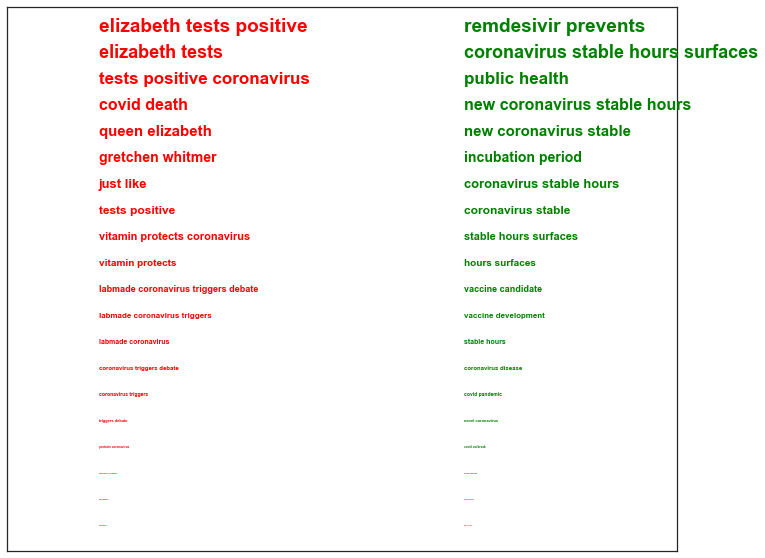

In [44]:
plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=([0] * 20), y=np.arange(0,20),size=np.zeros(20), sizes=(0,0))
ax.set(xticks=[], yticks=[])
ax.legend().set_visible(False)

c=0
# label points on the p
for x, z in zip(([-0.04] * 20), np.arange(0,20)):
 plt.text(x= x, y=z, color="red",s = score_fake[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1

c=0
# label points on the p
for x, z in zip(([0.02] * 20), np.arange(0,20)):
 plt.text(x= x, y=z, color="green", s = score_real[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1


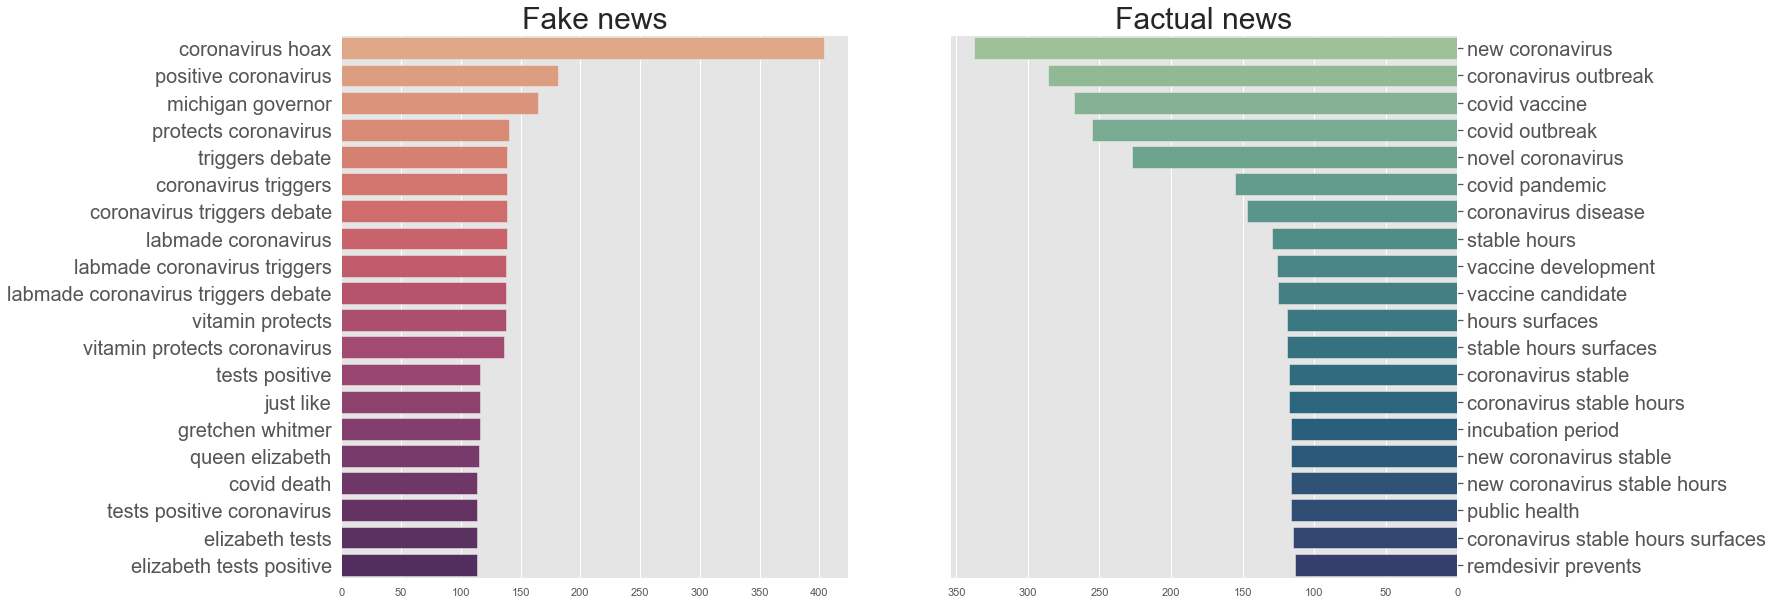

In [45]:
with plt.style.context('ggplot'):
  f = plt.figure(figsize=(20,10))
  ax0 = plt.subplot(121)
  sns.barplot(ax=ax0, y=score_fake[0], x=score_fake[1], palette="flare")
  plt.title('Fake news',fontsize=30)
  plt.yticks(fontsize=20)

  ax1 = plt.subplot(122)
  sns.barplot(ax=ax1, y=score_real[0], x=score_real[1], palette="crest")
  plt.title('Factual news',fontsize=30)
  ax1.yaxis.set_ticks_position("right")
  plt.yticks(fontsize=20)
  ax1.invert_xaxis()
  
  plt.show()

## Training and Testing model

DecisionTree classifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(18310, 1000) (18310,)
(4578, 1000) (4578,)


In [47]:
decisiontree_tfidf = DecisionTreeClassifier(max_depth=3)
decisiontree_tfidf.fit(X_train, y_train)
print("accuracy score of decision tree: ", decisiontree_tfidf.score(X_test, y_test))

accuracy score of decision tree:  0.5755788553953691


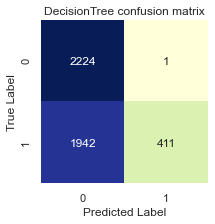

In [48]:
# Performance visualisation 
predictions = decisiontree_tfidf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d',cmap = "YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DecisionTree confusion matrix')
plt.show()

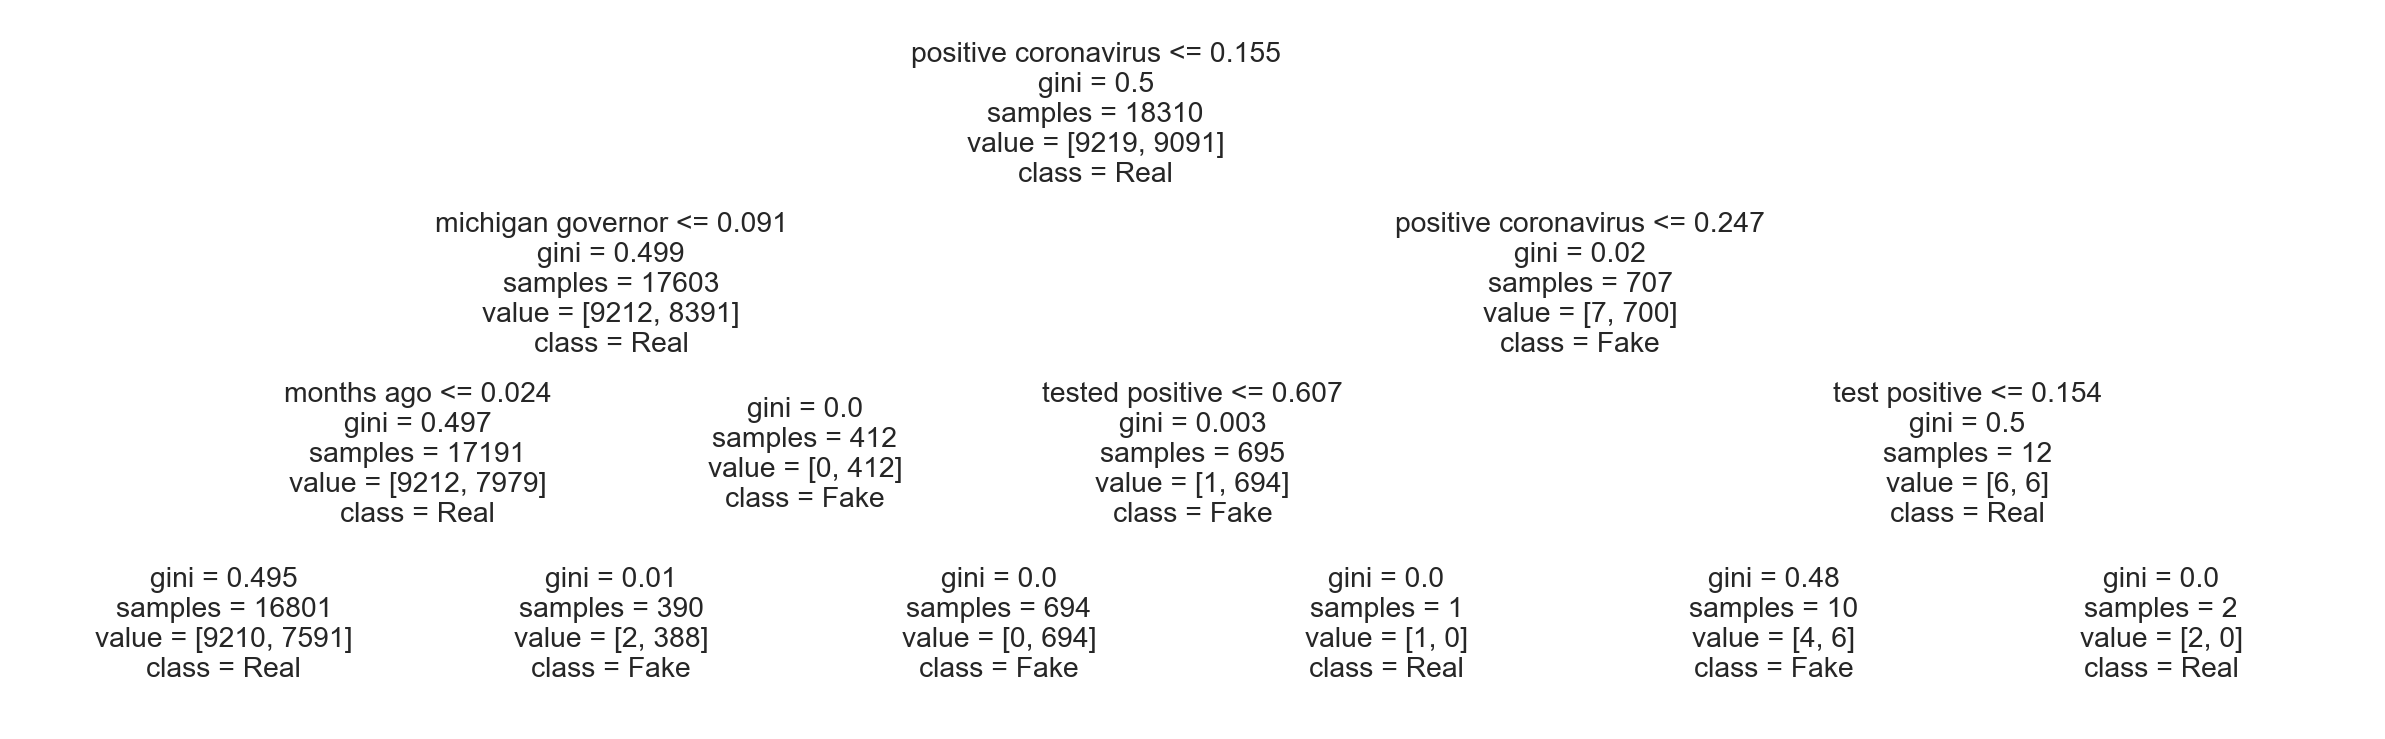

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(decisiontree_tfidf, feature_names = features,
                class_names = ["Real", "Fake"])
plt.show()

RandomForest classifier

In [50]:
randomforest_tfidf = RandomForestClassifier(n_estimators=20, max_depth=90).fit(X_train, y_train)
print("accuracy_score of RandomForest: ", randomforest_tfidf.score(X_test, y_test))

accuracy_score of RandomForest:  0.9108781127129751


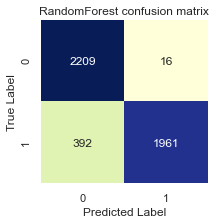

In [51]:
# Performance visualisation 
predictions = randomforest_tfidf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForest confusion matrix')
plt.show()

Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# instantiate a logistic regression model
logistic_tfidf = LogisticRegression()
logistic_tfidf.fit(X_train, y_train)
print("accuracy score of logisticReg: ", logistic_tfidf.score(X_test, y_test))

accuracy score of logisticReg:  0.9141546526867628


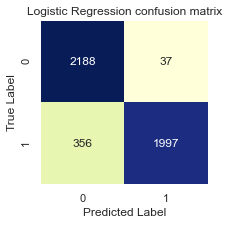

In [53]:
# Performance visualisation 
predictions = logistic_tfidf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression confusion matrix')
plt.show()

Linear SVM

In [54]:
from sklearn.svm import LinearSVC
linearSVM = LinearSVC()
linearSVM.fit(X_train, y_train)
print("accuracy score of linear SVM: ", linearSVM.score(X_test, y_test))

accuracy score of linear SVM:  0.9143730886850153


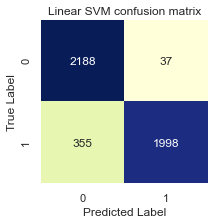

In [55]:
# Performance visualisation 
predictions = linearSVM.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear SVM confusion matrix')
plt.show()

AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

AdB_model = AdaBoostClassifier()    
AdB_model.fit(X_train, y_train)
print('accuracy:',AdB_model.score(X_test,y_test))

accuracy: 0.8966797728265619


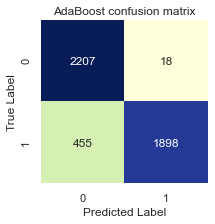

In [57]:
# Performance visualisation 
predictions = AdB_model.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AdaBoost confusion matrix')
plt.show()

In [58]:
tweets_and_users["is_tfidf_fake"] = [k[1] for k in randomforest_tfidf.predict_proba(tfidf.transform(tweets_and_users["full_text"]))]

# Training and testing model on features

In this section, we will train classifiers on all the features that we have collected in the data analysis part. 

## Features

In [59]:
columns = ["retweet_count","favorite_count", "n_nnp", "n_exclaim", "n_hash", 'n_uppercase', "is_tfidf_fake"]
X = tweets_and_users[columns].reset_index(drop=True)
y = tweets_and_users['label'].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

## Training and testing

Decision Tree

In [60]:
DTmodel = DecisionTreeClassifier(max_depth=3)
DTmodel.fit(X_train, y_train)

y_ = DTmodel.predict(X_test)
y_pred = DTmodel.predict(X)
DTmodel.score(X_test, y_test)

0.9565

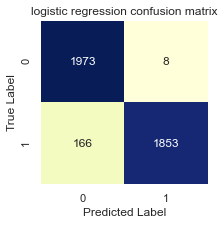

In [61]:
predictions = DTmodel.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('logistic regression confusion matrix')
plt.show()

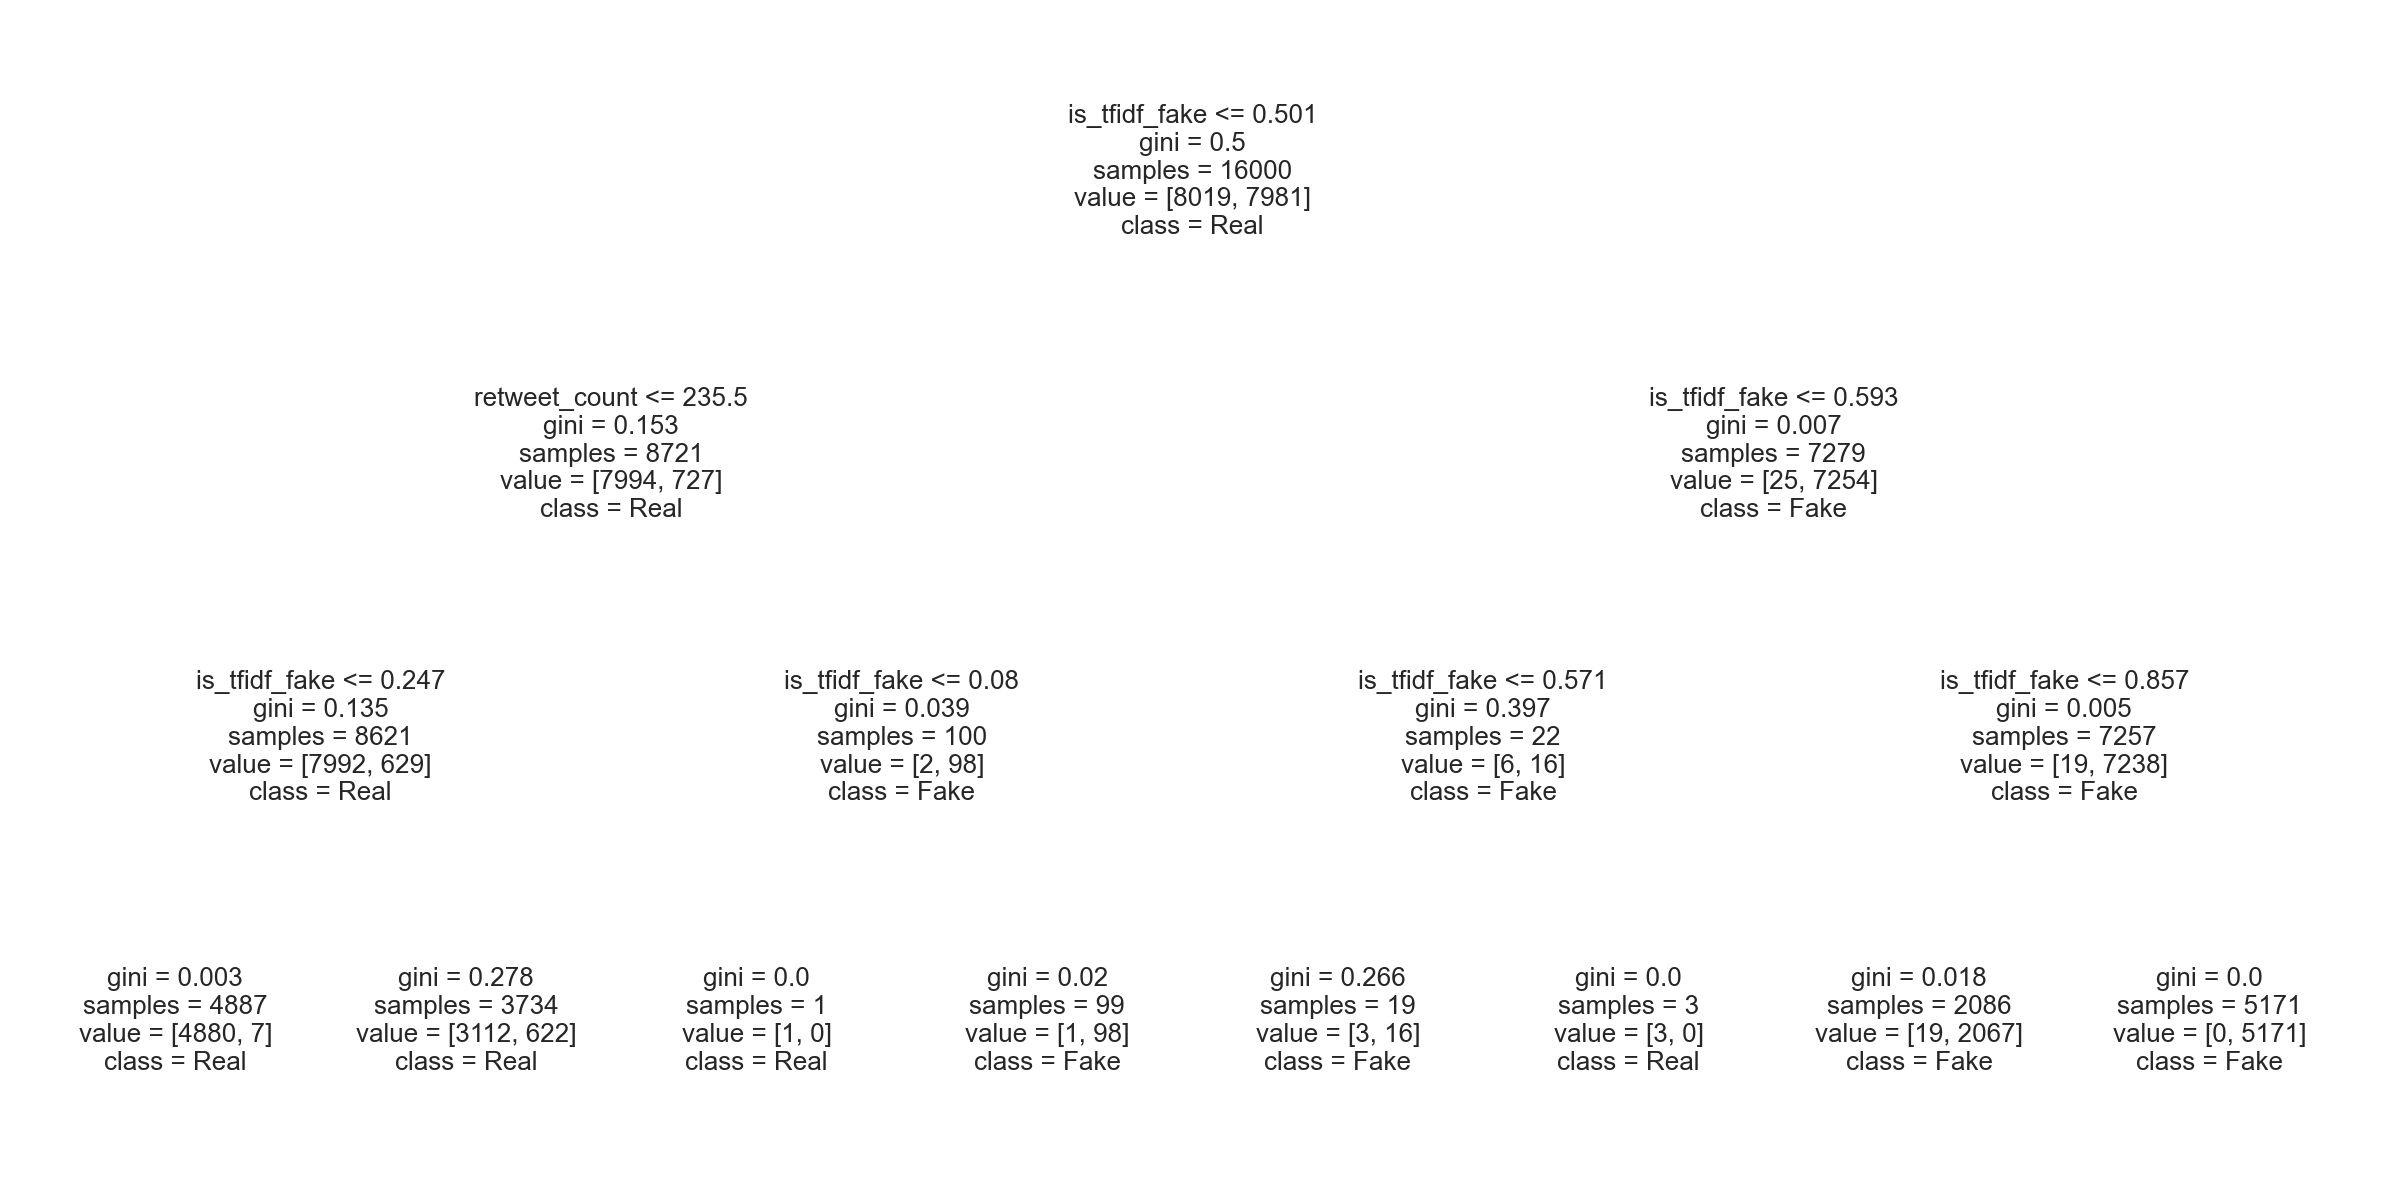

In [62]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), dpi=300)
tree_dot = plot_tree(DTmodel, feature_names = columns,
                class_names = ["Real", "Fake"])
plt.show()

Random Forest

In [63]:
RFmodel = RandomForestClassifier(n_estimators=20, max_depth=90).fit(X_train, y_train)
print("accuracy_score of RandomForest: ", RFmodel.score(X_test, y_test))

accuracy_score of RandomForest:  0.9665


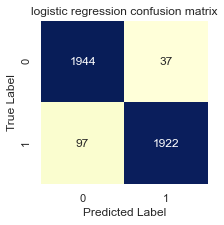

In [64]:
predictions = RFmodel.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('logistic regression confusion matrix')
plt.show()

Logisitc Regression

In [65]:
logistic_tfidf = LogisticRegression()
logistic_tfidf.fit(X_train, y_train)
print("accuracy score of logisticReg: ", logistic_tfidf.score(X_test, y_test))

accuracy score of logisticReg:  0.96


/Users/manmanhuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


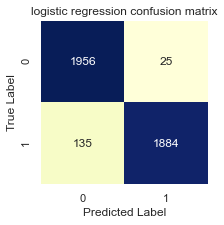

In [66]:
predictions = logistic_tfidf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('logistic regression confusion matrix')
plt.show()

Linear SVM

In [67]:
from sklearn.svm import LinearSVC
linearSVM = LinearSVC()
linearSVM.fit(X_train, y_train)
print("accuracy score of linear SVM: ", linearSVM.score(X_test, y_test))

accuracy score of linear SVM:  0.95725


/Users/manmanhuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


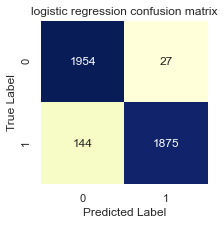

In [68]:
predictions = linearSVM.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('logistic regression confusion matrix')
plt.show()

AdaBoost

In [69]:
from sklearn.ensemble import AdaBoostClassifier

AdB_model = AdaBoostClassifier()    
AdB_model.fit(X_train, y_train)
print('accuracy:',AdB_model.score(X_test,y_test))

accuracy: 0.964


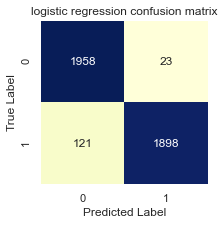

In [70]:
predictions = AdB_model.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('logistic regression confusion matrix')
plt.show()